# Analysis of Covid-19 paper

#### Sepideh Ghaemifar 2072829,  Mahdy Vatankhahan 2072069, Abbas Zal 2072054 , Ehsan Eslami Shafigh 2070769

We start each task by presenting the results for benchmarking of that task. You can find the code for the benchmarking in a separate notebook for each task. Then we choose the best parameters found to run the whole code for the task. We use a dataset of approximately 1000 papers.

In [1]:
import os
import dask
import ast
import json
from dask import delayed, compute
import io
from dask.distributed import LocalCluster
import dask.array as da
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import dask.bag as db
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
import dask.dataframe as ddf
import csv
import numpy as np
import string
import time
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
from dask.distributed import SpecCluster
from collections import Counter
import re
import seaborn as sns
import ast
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap
from operator import add
from wordcloud import WordCloud


# Download stopwords only once
nltk.download('stopwords')

# Create a list of stopwords in English
stopwords_list = stopwords.words('english')

# Set options for pandas to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from dask.distributed import Client, SSHCluster

machine1 = '10.67.22.152'
machine2 = '10.67.22.250'
#machine3 = '10.67.22.254'

In [3]:
cluster = SSHCluster([machine1,machine1, machine2],
                    scheduler_options={"port": 0, "dashboard_address": ":8787"}
                    ,worker_options={"n_workers":8})

client = Client(cluster)

2023-07-09 15:45:21,336 - distributed.deploy.ssh - INFO - 2023-07-09 15:45:21,333 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-09 15:45:21,394 - distributed.deploy.ssh - INFO - 2023-07-09 15:45:21,392 - distributed.scheduler - INFO - State start
2023-07-09 15:45:21,400 - distributed.deploy.ssh - INFO - 2023-07-09 15:45:21,398 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:40199
2023-07-09 15:45:22,843 - distributed.deploy.ssh - INFO - 2023-07-09 15:45:22,841 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.152:42297'
2023-07-09 15:45:22,848 - distributed.deploy.ssh - INFO - 2023-07-09 15:45:22,847 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.152:38419'
2023-07-09 15:45:22,853 - distributed.deploy.ssh - INFO - 2023-07-09 15:45:22,852 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.15

In [4]:
client

<Client: 'tcp://10.67.22.152:40199' processes=0 threads=0, memory=0 B>

In [5]:
folder_path =  '/mnt/covid/data/papers1'
file_list = os.listdir(folder_path)

## Task 1:  Distributed Word Counter Algorithm:

In this task, we have implemented a distributed algorithm that efficiently counts the occurrences of words within a list of documents. We leverage the Bag data structure provided by DASK to facilitate the process. In this section, we will walk through the algorithm step by step and present a consolidated function that enables us to measure the computational time required by the algorithm.

### Benchmarking Results

<div style="display: flex;">
    <div style="flex: 50%;">
        <img src="1-1.png" alt="Image 1" style="width: 100%;">
    </div>
    <div style="flex: 50%;">
        <img src="1-2.png" alt="Image 2" style="width: 100%;">
    </div>
</div>


load_json(filename, folder_path):

Takes a filename parameter and loads the content of the JSON file located at folder_path/filename.
It uses the json.load() function to read and parse the JSON data from the file.
The function then returns the loaded JSON data as a Python object.


mk_str(paper):

Takes a paper parameter, representing a single paper from the loaded JSON data.
It creates a translation table using str.maketrans() and string.punctuation to remove punctuation marks from the text.
It iterates through each text entry in the 'body_text' section of the paper.
For each text entry, it applies the translation table to remove punctuation and appends the cleaned text to a list.
Finally, it joins all the cleaned text entries into a single string using ''.join() and splits it into a list of words using split().
The resulting list contains all the words from the paper without punctuation.

In [6]:
def load_papers(filename):
    
    with open(os.path.join(folder_path, filename), 'r') as file:
        json_data = json.load(file)
        
    return json_data

def mk_str(paper):
    translator = str.maketrans('', '', string.punctuation)
    trans_texts = [paper['body_text'][i]['text'].translate(translator) for i in range(len(paper['body_text']))]
    string_texts = ''.join(trans_texts)
    return list(string_texts.split())

In this part of the project, we focused on data processing and filtering to prepare the text data for further analysis. 

Defining Additional Words to Omit.
We defined a list called omit_words that contains specific words to be omitted from the word list during the filtering process. They were identified as non-informative or irrelevant for our analysis.


Removing Stopwords, Additional Words, and Numbers.
To clean the word list further, we utilized the NLTK library's stopwords module, which provides a list of common English stopwords. We removed these stopwords, along with the additional words defined in the omit_words list, from the word list. This filtering process helps eliminate commonly used words that do not carry significant meaning for our analysis.



### Map Phase

In [7]:
# # Define the additional words to omit
omit_words = ['et', 'al', 'also', 'may', 'fig', 'der', 'p', 'h', 'using', 'used', 'ma', 'de', 'however' , 'one' , 'two']

# # Remove stopwords, additional words, and numbers from the word list
stopwords_list = stopwords.words('english')


filtered_word_list = (db.from_sequence(file_list).map(load_papers).map(mk_str).repartition(8).flatten()
                     .map(lambda word: word.lower())
                     .filter(lambda word: word not in stopwords_list and word not in omit_words and word.isalpha())).persist()

This data processing and filtering pipeline ensures that the word list contains relevant and meaningful words for the subsequent analysis steps. By removing stopwords, specific additional words, and numbers, we focus our analysis on the most informative and significant terms. The use of Dask's parallel computing capabilities also enables efficient processing of a large number of files in a distributed manner.

### Reduce Phase


We utilized the foldby() function, which is a powerful Dask operation, to perform the summation of word occurrences. The foldby() function combines values within the bag based on a key and applies a reduction function to aggregate those values.

In [8]:
# Apply foldby() to sum the occurrences of each word
result = filtered_word_list.foldby(lambda x: x, lambda x , _ : x + 1, initial= 0 , combine = add)
result.persist()

dask.bag<foldby-b, npartitions=1>

The result of the foldby() operation, which contains the word occurrences, was converted to a Dask DataFrame using the to_dataframe() method. We specified the desired column names as ['Word', 'Count'] to appropriately label the columns in the resulting DataFrame.

In [9]:
# Convert to a Dask DataFrame
df = result.to_dataframe(columns=['Word', 'Count']).compute()

Sorting the DataFrame:

The obtained pandas DataFrame was sorted in descending order based on the "Count" column using the sort_values() method. By setting ascending=False, we ensured that the DataFrame was sorted in descending order, with the highest word counts appearing first.

In [10]:
# Sort the DataFrame in descending order based on the "Count" column
df_sorted = df.sort_values('Count', ascending=False)
df_sorted.head(10)

,Word,Count
369,cells,18492
387,virus,15414
3,infection,12341
217,viral,10001
1564,protein,9182
606,cell,8723
10,disease,8195
2313,study,7779
354,patients,7656
167,viruses,6914


The resulting sorted DataFrame, as shown by the df_sorted.head(10) command, presents the top 10 words with the highest counts. These words are of particular interest as they provide insights into the most prevalent terms within the analyzed documents.

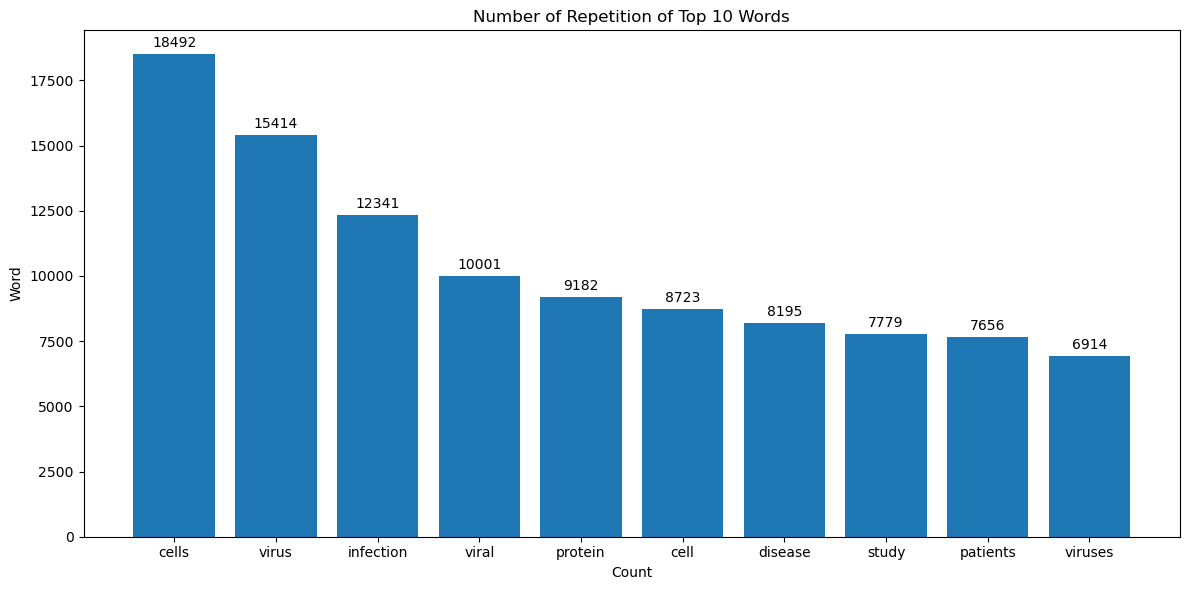

In [11]:
# Set the figure size and create subplots
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Bar chart subplot
bars = ax1.bar(df_sorted['Word'][:10], df_sorted['Count'][:10])
ax1.set_title('Number of Repetition of Top 10 Words')
ax1.set_xlabel('Count')
ax1.set_ylabel('Word')
ax1.tick_params(axis='y', rotation=0)  # Set rotation to 0 for horizontal word display

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

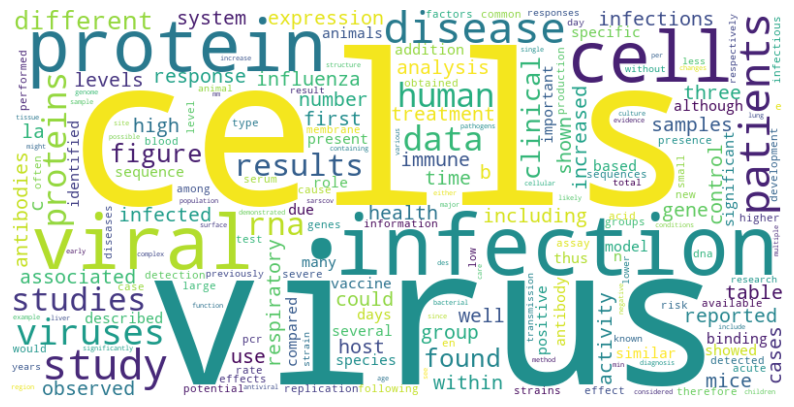

In [12]:
# Convert the DataFrame into a dictionary of word-frequency pairs
word_freq = dict(zip(df_sorted['Word'], df_sorted['Count']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Task 2: Finding most/least number of papers according to both the country and university names of the authors.

### Benchmarking Results

We have two set of optimum parameters for the two sub tasks in task 2:

For the country sub_task we have the heatmap (and the corresponding plot) showing the average time of 5 different tries for each pair of the partitioning number and the total number of workers in the cluster with having the fix number of threads = 4 the whole time. The whole process was being experienced for a number of 1000 papers.


<div style="display: flex;">
    <div style="flex: 50%;">
        <img src="2-1.png" alt="Image 1" style="width: 100%;">
    </div>
    <div style="flex: 50%;">
        <img src="2-2.png" alt="Image 2" style="width: 100%;">
    </div>
</div>


The same prcess is applied for the University sub_task and here are the results:

<div style="display: flex;">
    <div style="flex: 50%;">
        <img src="2-3.png" alt="Image 1" style="width: 100%;">
    </div>
    <div style="flex: 50%;">
        <img src="2-4.png" alt="Image 2" style="width: 100%;">
    </div>
</div>


In the following, we are going to find countries/universities with most/least number of papers published

### Functions for the task 

Below are the main functions used for the task along with their respective purposes:

Main functions:

- `load_json_data(filename)`: Loads JSON files.
- `country_paper(paper)`: Extracts the country of the author. If there is no author, it outputs "NAuthor". If the country of the author is not specified, it returns "NN" (which applies to most papers in the dataset).
- `uni_paper(paper)`: Performs the same purpose as `country_paper(paper)`, but for finding the university of authors.

Side functions:

By utilizing the other functions mentioned above, we were able to clean the tail below as much as possible!!

<img src="2-7.jpg" alt="Image" width="25%">

To describe the process of cleaning and this only goes for the country sub_task, we made a clean list of countries using the predefined list of countries that libraries "pycountry" and "iso3166" provided as our standard list of countries, we then cleaned our result in the same way and finally, compared our cleaned results with the standard list we made to find the clean corrected country names since as seen above, the dataset in too messy.   

In [13]:
import string
import re
from iso3166 import countries

translator = str.maketrans('', '', string.punctuation)

def load_json_data(filename):
    """
    Load JSON data from a file.

    Args:
        filename (str): Name of the JSON file.

    Returns:
        dict: Loaded JSON data as a dictionary.

    """
    with open(os.path.join(path, filename), 'r') as file:
        json_data = json.load(file)
    return json_data

def country_paper(paper):
    """
    Extract the countries mentioned in a paper's metadata.

    Args:
        paper (dict): Paper content as a dictionary.

    Returns:
        list: List of country names mentioned in the paper.

    """
    countries = []
    
    if 'authors' in paper['metadata']:
        authors = paper['metadata']['authors']
        if len(authors) > 0:
            for author in authors:
                if 'affiliation' in author:
                    affiliation = author['affiliation']
                    if 'location' in affiliation:
                        location = affiliation['location']
                        if 'country' in location:
                            country = location['country']
                            if len(country) == 0:
                                countries.append('NN') 
                            else:
                                countries.append(country)
                        else:
                            countries.append('NN')
                    else:
                        countries.append('NN')
                else:
                    countries.append('NN')
        else:
            countries.append('NAuthor')
    return countries

def replace_elements(l1, l2, l3):
    """
    Replace elements in a list based on a mapping dictionary.

    Args:
        l1 (list): List to modify.
        l2 (list): List of elements to replace.
        l3 (list): List of replacement elements.

    Returns:
        list: Modified list with replaced elements.

    """
    element_map = {key: value for key, value in zip(l2, l3)}
    result = [element_map.get(element, element) for element in l1]
    return result

def preprocess_string(string):
    """
    Preprocess a string by cleaning and filtering its content.

    Args:
        string (str): Input string.

    Returns:
        list: List of filtered words.

    """
    cleaned_string = re.sub(r'[^a-zA-Z\s]', '', string)
    words = list(set(cleaned_string.lower().strip().split()))
    filtered_words = [word.translate(translator) for word in words if word.lower() not in stopwords_list]
    return filtered_words

def process_country_data(clist, flattened_list2):
    """
    Process country data to standardize country names.

    Args:
        clist (list): List of country names to process.
        flattened_list2 (list): Flattened list of preprocessed country names.

    Returns:
        list: List of standardized country names.

    """
    l_change = ['kingdom' , 'america' , 'zealand' , 'arabia' , 'us']
    l_standard = ['uk', 'usa', 'newzealand', 'saudiarabia' , 'usa']
    nested_list_country = [preprocess_string(word) for word in clist]
    flattened_list = [item for sublist in nested_list_country for item in sublist]
    final_country_change = [item for item in flattened_list if item in flattened_list2]
    final_country = replace_elements(final_country_change , l_change , l_standard )
    return final_country

def remove_values_from_list(lst, values_to_remove):
    """
    Remove specific values from a list.

    Args:
        lst (list): List to modify.
        values_to_remove (list): List of values to remove.

    Returns:
        list: Modified list with values removed.

    """
    result = [x for x in lst if x not in values_to_remove]
    return result

def uni_paper(paper):
    """
    Extract the universities mentioned in a paper's metadata.

    Args:
        paper (dict): Paper content as a dictionary.

    Returns:
        dict: Dictionary with universities and their respective counts.

    """
    uni = []
    
    if 'authors' in paper['metadata']:
        authors = paper['metadata']['authors']
        if len(authors) > 0:
            for author in authors:
                if 'affiliation' in author:
                    affiliation = author['affiliation']
                    if 'institution' in affiliation:
                        institution = affiliation['institution']
                        if len(institution) == 0:
                            uni.append('NN')
                        else:
                            uni.append(institution)    
                    else:
                        uni.append('NN')
                else:
                    uni.append('NN')
        else:
            uni.append('NA')

    return uni

### Path/List of the JSON files 

In [14]:
path = '/mnt/covid/data/papers1'
json_list = os.listdir(path)

### The standard list of countries!

In [15]:
clist2 = [country.name for country in countries]
nested_list_country2 = [preprocess_string(word) for word in clist2]
flattened_list2 = list([item for sublist in nested_list_country2 for item in sublist])
flattened_list2.extend(['usa' , 'uk' , 'nn' , 'nauthor'])
flattened_list2 = remove_values_from_list(flattened_list2 , ['united' , 'states' , 'new' , 'peoples' , 'islamic' , 'republic' , 'saudi'])

### Countries with most papers published (top 20)

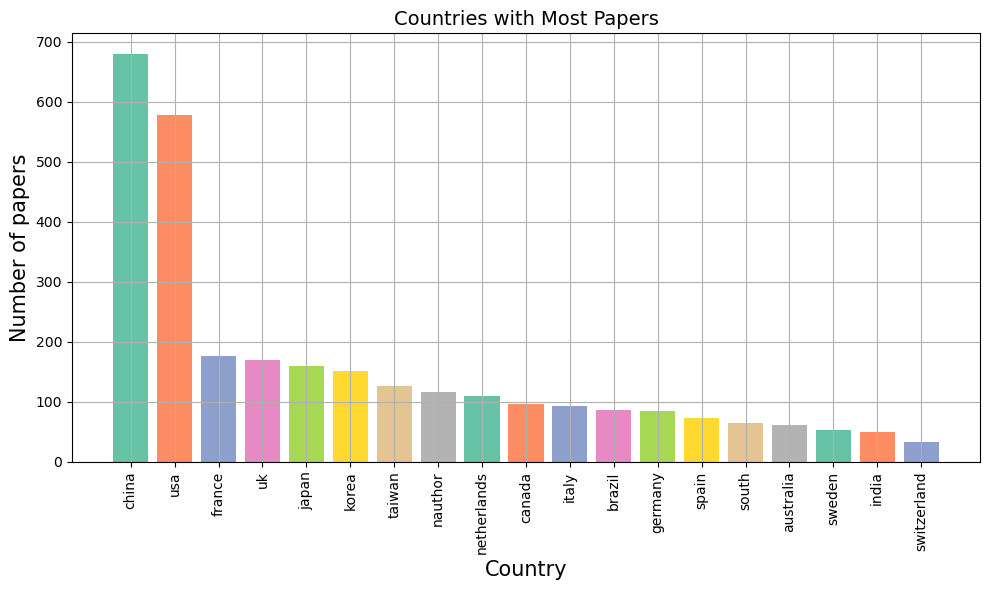

In [16]:
n_paper = 1000
n_repartition = 60
amount = 20

df_country = (
    db.from_sequence(json_list[0:n_paper] , partition_size = n_repartition)
    .map(load_json_data)
    .map(country_paper)
    .map(lambda x: process_country_data(x , flattened_list2))
    .flatten()
    .frequencies()
    .to_dataframe(columns=['Country', 'Count'])
    .nlargest(n=amount, columns='Count')
)

head = df_country.compute()

# Set the color palette
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 6))
plt.bar(head['Country'][1:], head['Count'][1:], color=colors)

# Adjusting font size for all elements
fs = 15
plt.xlabel('Country', fontsize=fs)
plt.ylabel('Number of papers', fontsize=fs)
plt.title('Countries with Most Papers', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines
plt.grid(True)

# Adjusting spacing
plt.tight_layout()

# Display the plot
plt.show()

#### Below you can see the results from another dataset:

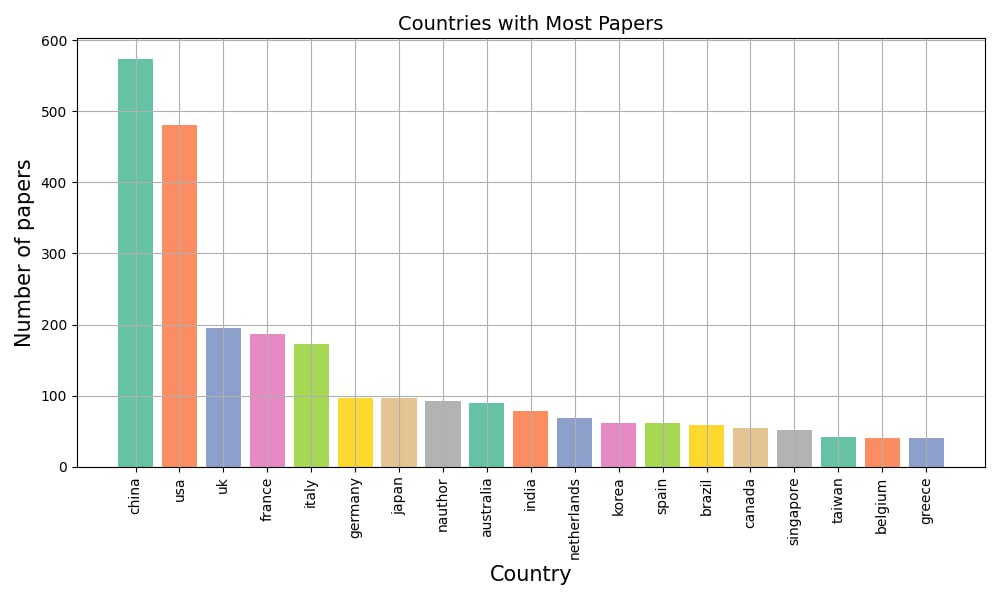

### Countries with least papers published (last 20)

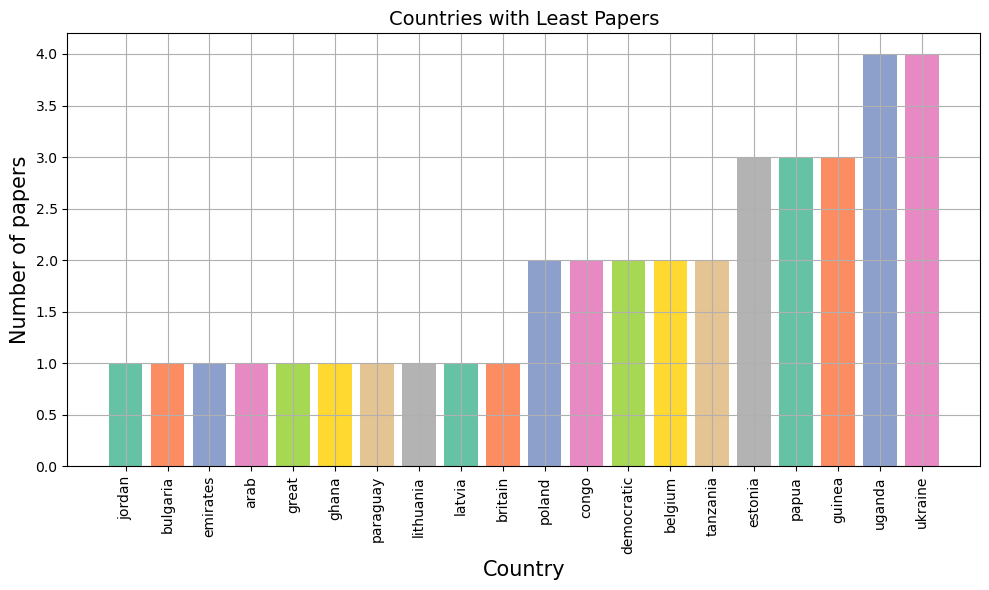

In [17]:
df_country = (
    db.from_sequence(json_list[0:n_paper], partition_size = n_repartition)
    .map(load_json_data)
    .map(country_paper)
    .map(lambda x: process_country_data(x , flattened_list2))
    .flatten()
    .frequencies()
    .to_dataframe(columns=['Country', 'Count'])
    .nsmallest(n=amount, columns='Count')
)

tail = df_country.compute()


# Set the color palette
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 6))
plt.bar(tail['Country'], tail['Count'], color=colors)

# Adjusting font size for all elements
fs = 15
plt.xlabel('Country', fontsize=fs)
plt.ylabel('Number of papers', fontsize=fs)
plt.title('Countries with Least Papers', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines
plt.grid(True)

# Adjusting spacing
plt.tight_layout()

# Display the plot
plt.show()

#### Below you can see the results from another dataset:

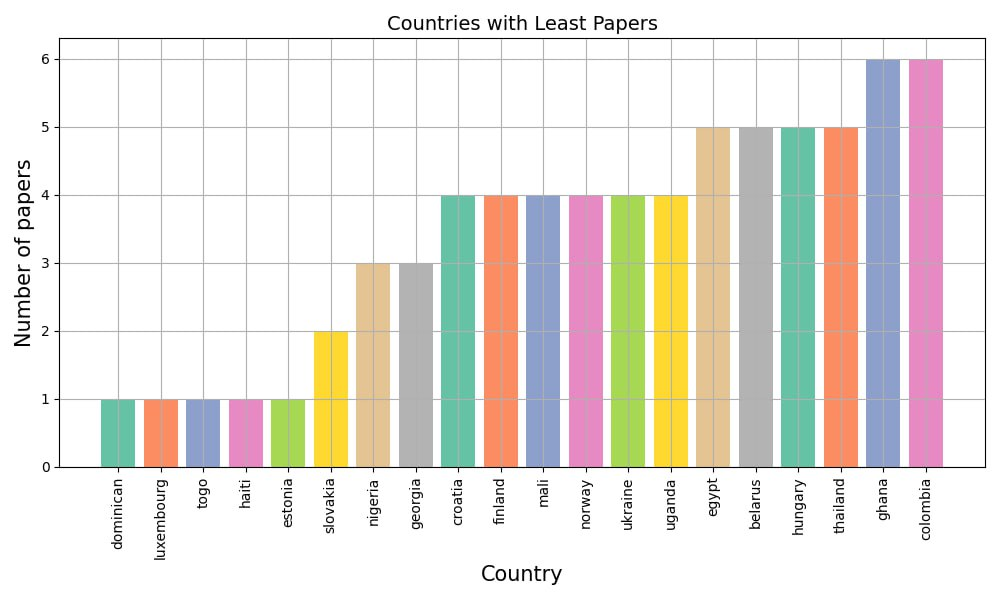

### Universities with most papers published (top 20)

In [18]:
df_uni = (
    db.from_sequence(json_list[0:n_paper], partition_size = 75)
    .map(load_json_data)
    .map(uni_paper)
    .flatten()
    .frequencies()
    .to_dataframe(columns=['University', 'Count'])
    .nlargest(n=amount, columns='Count')
)

head = df_uni.compute()

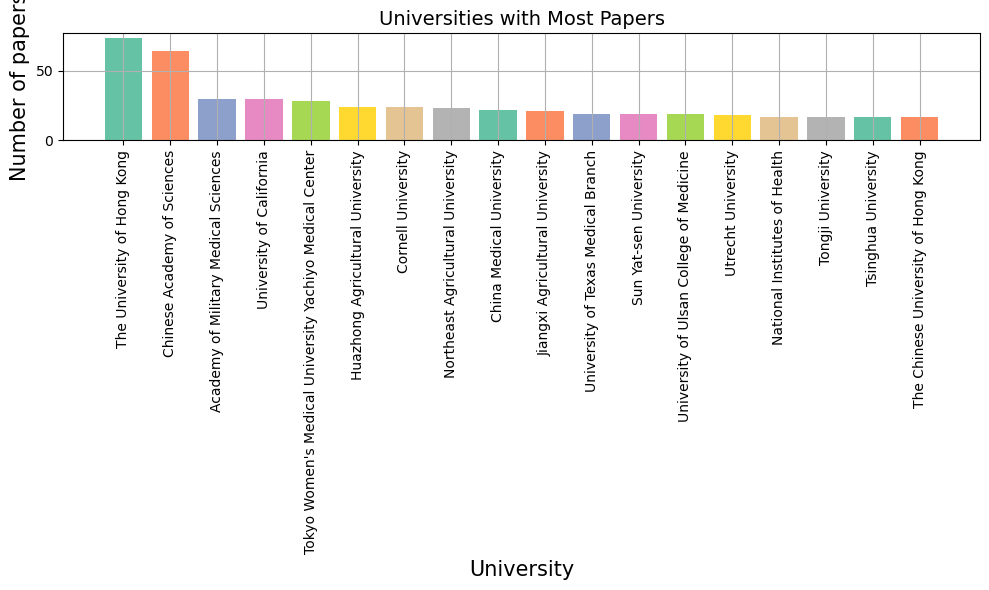

In [19]:
# Set the color palette
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 6))
plt.bar(head['University'][2:], head['Count'][2:], color=colors)

# Adjusting font size for all elements
fs = 15
plt.xlabel('University', fontsize=fs)
plt.ylabel('Number of papers', fontsize=fs)
plt.title('Universities with Most Papers', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines
plt.grid(True)

# Adjusting spacing
plt.tight_layout()

# Display the plot
plt.show()

#### Below you can see the results from another dataset:

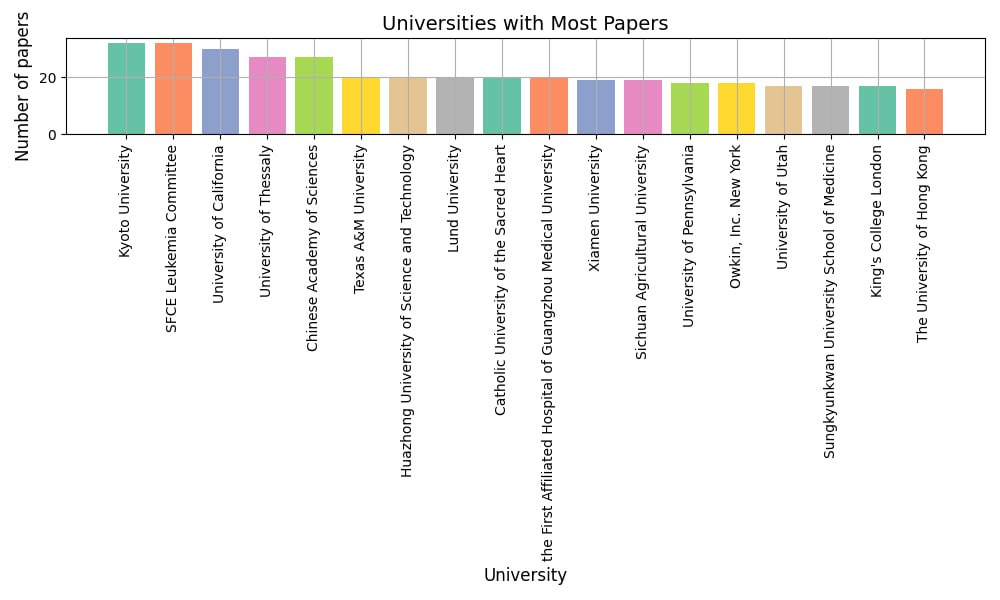

### Universities with least papers published (last 20)

In [20]:
df_country = (
    db.from_sequence(json_list[0:n_paper], partition_size = 75)
    .map(load_json_data)
    .map(uni_paper)
    .flatten()
    .frequencies()
    .to_dataframe(columns=['University', 'Count'])
    .nsmallest(n=amount, columns='Count')
)
# df_country.visualize(filename='df.png')
tail = df_country.compute()


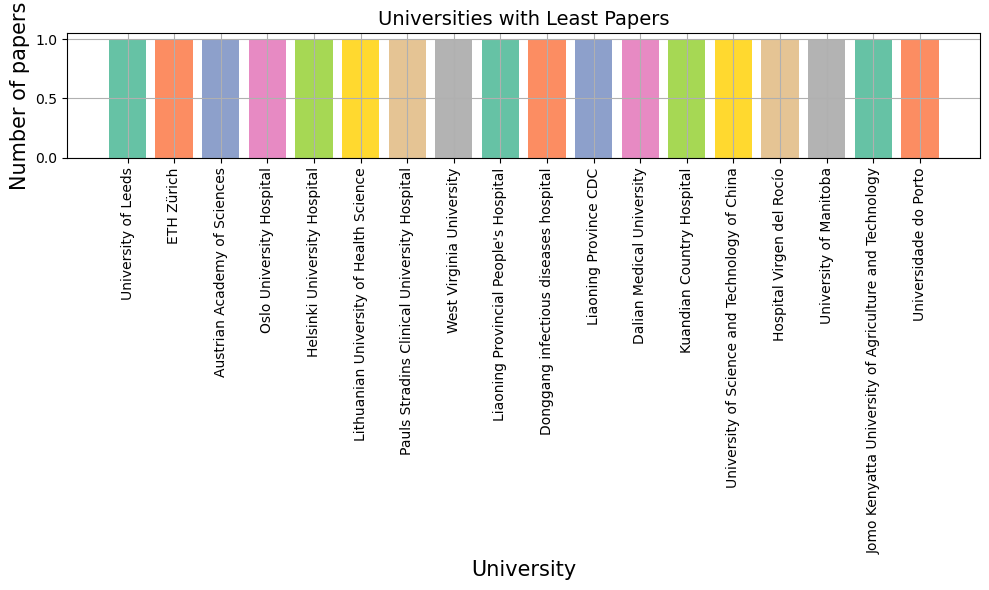

In [21]:
# Set the color palette
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 6))
plt.bar(tail['University'][2:], tail['Count'][2:], color=colors)

# Adjusting font size for all elements
fs = 15
plt.xlabel('University', fontsize=fs)
plt.ylabel('Number of papers', fontsize=fs)
plt.title('Universities with Least Papers', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines
plt.grid(True)

# Adjusting spacing
plt.tight_layout()

# Display the plot
plt.show()

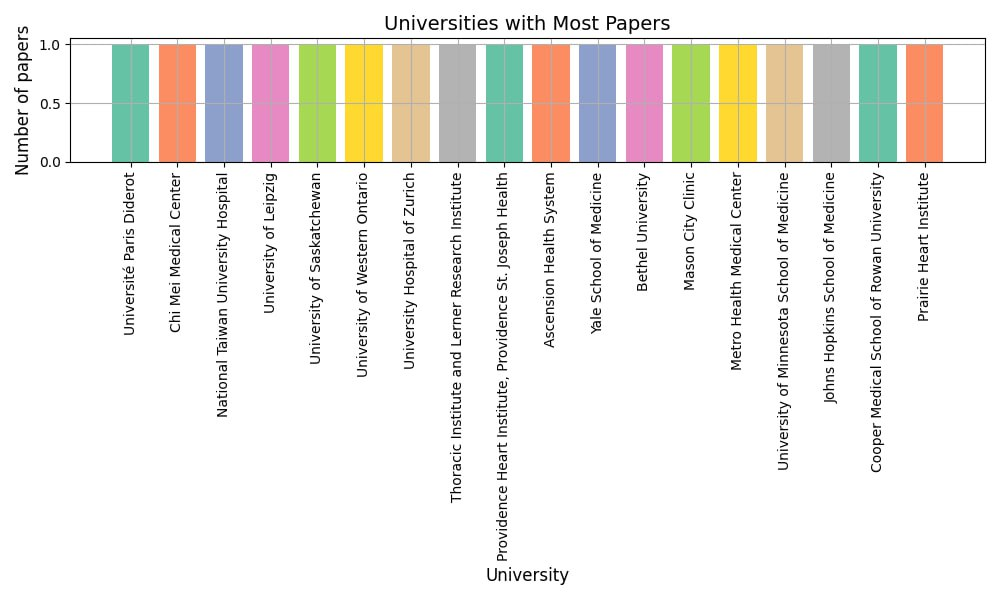

### Closing the client

In [22]:
client.close()
cluster.close()
client.shutdown()

## Task 3: Embedding For The Title of The Papers

### Benchmarking Results

<div style="display: flex;">
    <div style="flex: 50%;">
        <img src="3-1.png" alt="Image 1" style="width: 100%;">
    </div>
    <div style="flex: 50%;">
        <img src="3-2.png" alt="Image 2" style="width: 100%;">
    </div>
</div>


As you can see from the results above, the best choice of parameters for task 3 are 8 workers and 4 partitions. 

In [23]:
cluster = SSHCluster([machine1,machine1, machine2],
                    scheduler_options={"port": 0, "dashboard_address": ":8787"}
                    ,worker_options={"n_workers":4})

client = Client(cluster)

2023-07-09 15:46:52,664 - distributed.deploy.ssh - INFO - 2023-07-09 15:46:52,662 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-09 15:46:52,724 - distributed.deploy.ssh - INFO - 2023-07-09 15:46:52,722 - distributed.scheduler - INFO - State start
2023-07-09 15:46:52,730 - distributed.deploy.ssh - INFO - 2023-07-09 15:46:52,729 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:43081
2023-07-09 15:46:54,166 - distributed.deploy.ssh - INFO - 2023-07-09 15:46:54,164 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.152:33129'
2023-07-09 15:46:54,171 - distributed.deploy.ssh - INFO - 2023-07-09 15:46:54,169 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.152:38881'
2023-07-09 15:46:54,176 - distributed.deploy.ssh - INFO - 2023-07-09 15:46:54,175 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.15

In [24]:
client

<Client: 'tcp://10.67.22.152:43081' processes=8 threads=32, memory=62.01 GiB>

#### Functions for Task 3

In [25]:
def extract_titles(record):
    
    ID = record['paper_id']
    title = record['metadata']['title']
    title_tokens = word_tokenize(record['metadata']['title'])
    title_tokens_clean = [word.lower() for word in title_tokens\
                          if not word.lower() in stopwords.words('english') + ['use','used']\
                         and word.isalpha()] 
    
    return{'ID': ID,
          'title': title,
          'title_tokens': title_tokens_clean}

# Calculate the embedding matrix for a line
def calculate_embedding_matrix(line):
    keys = line
    values = [model.get(key) for key in keys if model.get(key)]
    matrix = [vector  for vector in values]
    return matrix

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    line_count = 0  # Track the number of lines read
    for line in fin:
        if line_count >= 10000:
            break  # Exit the loop after 100000 lines
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
        line_count += 1
    fin.close()  # Close the file after reading
    return data

We start by creating a dask bag from the papers again. The load_papers(filename) function is mapped on each JSON file in the folder path given at the begining:

In [26]:
# Create a Dask Bag to store the imported data
bag = db.from_sequence(file_list).map(load_papers)

For this task, we are only interested in the titles of the papers. We use the extract_titles(record) function defined above. The function keeps only the relavent data including the paper IDs and titles. Then the words in titles are tokenized, returning a list of them. The function also sanitizes the words by excluding the stopwords and words containing numbers. Finally, a dictionary with three keys is returned: {'ID': ID, 'title': title, 'title_tokens': title_tokens_clean}. We map the function on the bag we created earlier. 

In [27]:
titles = bag.map(extract_titles)

We continue by creating a dask dataframe out of the bag we had before the data frame will contain 3 columns as 'ID', 'title', 'title_tokens'. We also used persist() command to avoid  recomputations.

In [28]:
df_title = titles.to_dataframe(meta=pd.DataFrame(columns = ['ID', 'title', 'title_tokens' ])).repartition(4)
df_title.persist()

,ID,title,title_tokens
npartitions=4,,,
,object,object,object
,...,...,...
,...,...,...
,...,...,...
,...,...,...


Next, we load the pre-trained model available on the FastText. This is done using the load_vectors(fname) function. Note that, due to momory limitations, we are loading only the embedding vector of the first 10,000  words from the model.This is not a problem as the words in the model are sorted based on their occurence and they are enough to extract the context of the titles. With even tried 100,000 words from model and we did not see any significant difference in the results.

In [29]:
model = load_vectors('wiki.en.vec')

Next using the calculate_embedding_matrix(line) to extract the embedding matrix of each titles using the loaded model. The output is placed in the embedding matrix column.

In [30]:
df_title['embedding matrix'] = df_title['title_tokens'].map(calculate_embedding_matrix)
df_title.persist()

/root/miniconda3/lib/python3.10/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 26.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,ID,title,title_tokens,embedding matrix
npartitions=4,,,,
,object,object,object,object
,...,...,...,...
,...,...,...,...
,...,...,...,...
,...,...,...,...


In the dataset that we are using the titles for some papers are missing. As a result the calcualte embedding matrix function returns [] . We filter records containing [] from the dataframe.

In [31]:
# Drop records where 'embedding matrix' is equal to []
df_title = df_title.loc[~(df_title['title_tokens'].map(lambda x: x == []))]
df_title = df_title.loc[~(df_title['embedding matrix'].map(lambda x: x == []))]

In [32]:
df_title.compute()

/root/miniconda3/lib/python3.10/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 26.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,ID,title,title_tokens,embedding matrix
2,0af7147cccf23c134968cf9c5b9d357a7c179633,Real-time RT-PCR detection of Bovine Viral Dia...,"[detection, bovine, viral, diarrhoea, virus, w...","[[0.066268, 0.0727, -0.38468, 0.40713, -0.3595..."
3,0ed0bedd5005e893440208e3a176694c21e29db3,High Incidence of Multiple Viral Infections Id...,"[high, incidence, multiple, viral, infections,...","[[0.25761, 0.049883, 0.25229, 0.46973, 0.10346..."
0,0a04d377a83b28dbc0d97c90acd829255796f69c,Journal Pre-proof Anticancer activity studies ...,"[journal, anticancer, activity, studies, novel...","[[0.23255, -0.11983, -0.034624, 0.41877, -0.46..."
1,0cc828ff4caf234a7aba0a5e604939af5ab3c9e0,Nanostructuring Biopolymers for Improved Food ...,"[nanostructuring, biopolymers, improved, food,...","[[-0.085621, -0.036048, -0.36967, 0.44975, -0...."
2,0f4ba828d02ce360d619447eca378043b3da2387,Gastrointestinal Disease 11 Colic in the Newbo...,"[gastrointestinal, disease, colic, newborn, fo...","[[-0.1258, -0.12854, -0.27833, 0.32553, -0.134..."
0,0c3b3ae35af5de4b137bc3b40d6bf707c6b43cbc,Dynamics of a model with quarantine-adjusted i...,"[dynamics, model, incidence, quarantine, susce...","[[-0.14439, -0.096695, -0.17649, 0.68177, -0.2..."
1,0c48f849d10a2a1ad53b3653abb83f836bda7efe,Displasia ectodérmica anhidrótica asociada a d...,"[displasia, ectodérmica, anhidrótica, asociada...","[[-0.22543, -0.12547, 0.060058, -0.2338, 0.058..."
2,0c92f5b237572a3461ae2205a62ba7622c07a6ab,Send Orders for Reprints to reprints@benthamsc...,"[send, orders, reprints, reprints, role, neuro...","[[0.055077, 0.048137, 0.19387, 0.1843, 0.06382..."
3,0b530925f860fe1a3191519482c19e8240834caf,miRNA-200c-3p is crucial in acute respiratory ...,"[crucial, acute, respiratory, distress, syndrome]","[[-0.13358, -0.24957, -0.021418, 0.22322, 0.05..."
0,00fcc6277c19f6b180232d7a6fe0b0abfafb21f7,Clinical Features and Factors Associated with ...,"[clinical, features, factors, associated, seve...","[[0.36475, -0.060926, -0.21272, 0.35682, -0.34..."


## Task 4 : Cosine Similarity

### Benchmarking Results

<div style="display: flex;">
    <div style="flex: 50%;">
        <img src="4-1.png" alt="Image 1" style="width: 100%;">
    </div>
    <div style="flex: 50%;">
        <img src="4-2.png" alt="Image 2" style="width: 100%;">
    </div>
</div>


As you can see from the results above, the best choice of parameters for task 4 are 8 workers and 8 partitions. 

#### Functions for Task 4

In [33]:
# Calculate cosine similarity between two lines
def calculate_similarity(line1, line2):
    
    similarity = cosine_similarity(line1 , line2)
    return similarity

def max_finder(embed):
    
    max_sim = 0
    max_indx = 0
    
    for i in range(len(embedding_matrices)):
        
        sim = calculate_similarity(embed , embedding_matrices[i])[0][0]
        
        if sim > max_sim and sim < 0.99:
            
            max_sim = sim
            max_indx = i
            
    return (max_sim , max_indx)

The embedding matrix of each title containg m words is a matrix with m rows and 300 columns. To capture the context of each title, we average by row over each 300 dimension(column) and as a result we get a single row of 300 columns as the simplified embedding matrix of each title. 

In [34]:
df_title['embedding matrix'] = df_title['embedding matrix'].apply(lambda x: [np.mean(x , axis = 0)] , meta = ('x' , 'object'))

The function max_finder(embed) which will be using next, uses a list of embedding matrices to find the most similar paper to each paper in the dataset. We prepare the list beforehand:

In [35]:
embedding_matrices = df_title['embedding matrix'].compute().tolist()

/root/miniconda3/lib/python3.10/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 26.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [36]:
df_title.head(20)

/root/miniconda3/lib/python3.10/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 25.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


,ID,title,title_tokens,embedding matrix
2,0af7147cccf23c134968cf9c5b9d357a7c179633,Real-time RT-PCR detection of Bovine Viral Dia...,"[detection, bovine, viral, diarrhoea, virus, w...","[[0.07420122222222221, -0.05380766666666668, -..."
3,0ed0bedd5005e893440208e3a176694c21e29db3,High Incidence of Multiple Viral Infections Id...,"[high, incidence, multiple, viral, infections,...","[[0.07141559230769232, -0.06595082307692307, -..."
0,0a04d377a83b28dbc0d97c90acd829255796f69c,Journal Pre-proof Anticancer activity studies ...,"[journal, anticancer, activity, studies, novel...","[[0.10176566666666667, -0.026981444444444447, ..."
1,0cc828ff4caf234a7aba0a5e604939af5ab3c9e0,Nanostructuring Biopolymers for Improved Food ...,"[nanostructuring, biopolymers, improved, food,...","[[-0.14556260000000001, -0.08612420000000001, ..."
2,0f4ba828d02ce360d619447eca378043b3da2387,Gastrointestinal Disease 11 Colic in the Newbo...,"[gastrointestinal, disease, colic, newborn, fo...","[[-0.02514963636363637, -0.03647062727272726, ..."
0,0c3b3ae35af5de4b137bc3b40d6bf707c6b43cbc,Dynamics of a model with quarantine-adjusted i...,"[dynamics, model, incidence, quarantine, susce...","[[-0.026447333333333333, -0.02195, -0.25417, 0..."
1,0c48f849d10a2a1ad53b3653abb83f836bda7efe,Displasia ectodérmica anhidrótica asociada a d...,"[displasia, ectodérmica, anhidrótica, asociada...","[[-0.22543, -0.12547, 0.060058, -0.2338, 0.058..."
2,0c92f5b237572a3461ae2205a62ba7622c07a6ab,Send Orders for Reprints to reprints@benthamsc...,"[send, orders, reprints, reprints, role, neuro...","[[-0.09513375000000002, -0.09711825000000002, ..."
3,0b530925f860fe1a3191519482c19e8240834caf,miRNA-200c-3p is crucial in acute respiratory ...,"[crucial, acute, respiratory, distress, syndrome]","[[0.11427566666666668, -0.2836266666666667, -0..."
0,00fcc6277c19f6b180232d7a6fe0b0abfafb21f7,Clinical Features and Factors Associated with ...,"[clinical, features, factors, associated, seve...","[[0.02408428333333333, -0.12932316666666668, -..."


Since we need the indices in the dataframe need to be sorted and in the dask dataframe the indices are scrambled, we convert the dask dataframe we have to a panda dataframe and reindex the rows. Then we convert it back to a dask dataframe. We could not find an alternative way to do the reindexing. We set the number of the partitions equal to the optimum one obtained from benchmarking which for task 4 is 8. 

In [37]:
df_4 = df_title.compute()

/root/miniconda3/lib/python3.10/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 26.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [38]:
df_4 = df_4.reset_index( drop=True)

In [39]:
df_4.head(10)

,ID,title,title_tokens,embedding matrix
0,0af7147cccf23c134968cf9c5b9d357a7c179633,Real-time RT-PCR detection of Bovine Viral Dia...,"[detection, bovine, viral, diarrhoea, virus, w...","[[0.07420122222222221, -0.05380766666666668, -..."
1,0ed0bedd5005e893440208e3a176694c21e29db3,High Incidence of Multiple Viral Infections Id...,"[high, incidence, multiple, viral, infections,...","[[0.07141559230769232, -0.06595082307692307, -..."
2,0a04d377a83b28dbc0d97c90acd829255796f69c,Journal Pre-proof Anticancer activity studies ...,"[journal, anticancer, activity, studies, novel...","[[0.10176566666666667, -0.026981444444444447, ..."
3,0cc828ff4caf234a7aba0a5e604939af5ab3c9e0,Nanostructuring Biopolymers for Improved Food ...,"[nanostructuring, biopolymers, improved, food,...","[[-0.14556260000000001, -0.08612420000000001, ..."
4,0f4ba828d02ce360d619447eca378043b3da2387,Gastrointestinal Disease 11 Colic in the Newbo...,"[gastrointestinal, disease, colic, newborn, fo...","[[-0.02514963636363637, -0.03647062727272726, ..."
5,0c3b3ae35af5de4b137bc3b40d6bf707c6b43cbc,Dynamics of a model with quarantine-adjusted i...,"[dynamics, model, incidence, quarantine, susce...","[[-0.026447333333333333, -0.02195, -0.25417, 0..."
6,0c48f849d10a2a1ad53b3653abb83f836bda7efe,Displasia ectodérmica anhidrótica asociada a d...,"[displasia, ectodérmica, anhidrótica, asociada...","[[-0.22543, -0.12547, 0.060058, -0.2338, 0.058..."
7,0c92f5b237572a3461ae2205a62ba7622c07a6ab,Send Orders for Reprints to reprints@benthamsc...,"[send, orders, reprints, reprints, role, neuro...","[[-0.09513375000000002, -0.09711825000000002, ..."
8,0b530925f860fe1a3191519482c19e8240834caf,miRNA-200c-3p is crucial in acute respiratory ...,"[crucial, acute, respiratory, distress, syndrome]","[[0.11427566666666668, -0.2836266666666667, -0..."
9,00fcc6277c19f6b180232d7a6fe0b0abfafb21f7,Clinical Features and Factors Associated with ...,"[clinical, features, factors, associated, seve...","[[0.02408428333333333, -0.12932316666666668, -..."


In [40]:
ddf = dd.from_pandas(df_4, 8)

Now we are ready to apply the maxfinder(embed) to our dataframe. We apply the function on each record in the dataframe. It searches whithin the whole embedding matrices list we created earlier, to find the most similar embedding matrix to the current one. The similarity is evaluated by the calculate_similarity(line1, line2) function. In our case, it simply calcultes the cosine of the two embedding vectors in the 300 dimensional space. The maxfinder function save the value of the greatest cosine-similarity found together with the index of the corresponding paper. Finally it returns a tuple like (max_sim , max_indx).

In [41]:
result_4 = ddf['embedding matrix'].apply(max_finder, meta=('x', 'object')).compute()

To find the most similar couple of papers within the dataset, we find the maximum value of cosine-similarity in the corresponding column in the dataframe we just created.

In [42]:
pandas_series = pd.Series(result_4, name='intermediate results')

In [43]:
df_intermediate = pandas_series.apply(lambda x: pd.Series({'maximum similarity': x[0], 'most similar paper index': x[1]}))

In [44]:
df_intermediate['most similar paper index'] = df_intermediate['most similar paper index'].astype(int)

In [45]:
df_intermediate.head(10)

,maximum similarity,most similar paper index
0,0.892633,404
1,0.831931,144
2,0.757137,111
3,0.697953,787
4,0.826225,784
5,0.741696,847
6,0.937690,935
7,0.733505,290
8,0.873869,128
9,0.870429,61


In [46]:
# Concatenate the original_df and df_result vertically
df_final = pd.concat([df_4, df_intermediate], axis=1)

In [47]:
df_final = df_final.reset_index(drop=True)

In [48]:
df_final.head(20)

,ID,title,title_tokens,embedding matrix,maximum similarity,most similar paper index
0,0af7147cccf23c134968cf9c5b9d357a7c179633,Real-time RT-PCR detection of Bovine Viral Dia...,"[detection, bovine, viral, diarrhoea, virus, w...","[[0.07420122222222221, -0.05380766666666668, -...",0.892633,404
1,0ed0bedd5005e893440208e3a176694c21e29db3,High Incidence of Multiple Viral Infections Id...,"[high, incidence, multiple, viral, infections,...","[[0.07141559230769232, -0.06595082307692307, -...",0.831931,144
2,0a04d377a83b28dbc0d97c90acd829255796f69c,Journal Pre-proof Anticancer activity studies ...,"[journal, anticancer, activity, studies, novel...","[[0.10176566666666667, -0.026981444444444447, ...",0.757137,111
3,0cc828ff4caf234a7aba0a5e604939af5ab3c9e0,Nanostructuring Biopolymers for Improved Food ...,"[nanostructuring, biopolymers, improved, food,...","[[-0.14556260000000001, -0.08612420000000001, ...",0.697953,787
4,0f4ba828d02ce360d619447eca378043b3da2387,Gastrointestinal Disease 11 Colic in the Newbo...,"[gastrointestinal, disease, colic, newborn, fo...","[[-0.02514963636363637, -0.03647062727272726, ...",0.826225,784
5,0c3b3ae35af5de4b137bc3b40d6bf707c6b43cbc,Dynamics of a model with quarantine-adjusted i...,"[dynamics, model, incidence, quarantine, susce...","[[-0.026447333333333333, -0.02195, -0.25417, 0...",0.741696,847
6,0c48f849d10a2a1ad53b3653abb83f836bda7efe,Displasia ectodérmica anhidrótica asociada a d...,"[displasia, ectodérmica, anhidrótica, asociada...","[[-0.22543, -0.12547, 0.060058, -0.2338, 0.058...",0.937690,935
7,0c92f5b237572a3461ae2205a62ba7622c07a6ab,Send Orders for Reprints to reprints@benthamsc...,"[send, orders, reprints, reprints, role, neuro...","[[-0.09513375000000002, -0.09711825000000002, ...",0.733505,290
8,0b530925f860fe1a3191519482c19e8240834caf,miRNA-200c-3p is crucial in acute respiratory ...,"[crucial, acute, respiratory, distress, syndrome]","[[0.11427566666666668, -0.2836266666666667, -0...",0.873869,128
9,00fcc6277c19f6b180232d7a6fe0b0abfafb21f7,Clinical Features and Factors Associated with ...,"[clinical, features, factors, associated, seve...","[[0.02408428333333333, -0.12932316666666668, -...",0.870429,61


The final results are as follows:

In [49]:
# Locate the index of the record with the maximum value in 'Max_Similarity'
max_similarity_index = df_final['maximum similarity'].idxmax()

# Get the value of 'Max_Index' for that record
max_index = df_final.loc[max_similarity_index, 'most similar paper index']

# Get the titles for both records
max_similarity = df_final.loc[max_similarity_index, 'maximum similarity']
min_similarity_index = df_final['maximum similarity'].idxmin()
min_similarity = df_final.loc[min_similarity_index, 'maximum similarity']

title1 = df_final.loc[max_similarity_index, 'title']
title2 = df_final.loc[max_index, 'title']

# Print the titles and similarities
print('maximum similarity:')
print("Title 1:", title1)
print("Title 2:", title2)
print("Similarity:", max_similarity)

# Perform the same procedure for the minimum similarity
min_index = df_final.loc[min_similarity_index, 'most similar paper index']
min_title1 = df_final.loc[min_similarity_index, 'title']
min_title2 = df_final.loc[min_index, 'title']

print("Minimum Similarity:")
print("Title 1:", min_title1)
print("Title 2:", min_title2)
print("Similarity:", min_similarity)

maximum similarity:
Title 1: Cross-reactivity of antibody against SARS-coronavirus nucleocapsid protein with IL-11
Title 2: The SARS-CoV nucleocapsid protein: A protein with multifarious activities
Similarity: 0.9624411676204132
Minimum Similarity:
Title 1: Disassembly of the cystovirus /6 envelope by montmorillonite clay
Title 2: Avian and human influenza virus compatible sialic acid receptors in little brown bats OPEN
Similarity: 0.3644267003860126


In [50]:
client.close()
cluster.close()
client.shutdown()